In [497]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import lightgbm as lgb
import xgboost as xgb
import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [458]:
!pip install shap
import shap

In [2]:
pd.options.display.max_rows = 222
pd.set_option("display.max_columns", 50)

In [576]:
df_train = pd.read_csv(
    "../geekbrains-competitive-data-analysis/train.csv"
)

df_test = pd.read_csv(
    "../geekbrains-competitive-data-analysis/test.csv"
)

print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 110093 rows, 3 cols
df_test.shape = 165141 rows, 2 cols


In [257]:
#df_train = create_dummie(df_train)
#df_test = create_dummie(df_test)

df_train['NAME_CONTRACT_TYPE'] = (df_train['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)
df_test['NAME_CONTRACT_TYPE'] = (df_test['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)

In [333]:
df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)

print("sample_submit.shape = {} rows, {} cols".format(*df_sample_submit.shape))
df_sample_submit.head()

sample_submit.shape = 165141 rows, 2 cols


,APPLICATION_NUMBER,TARGET
0,123724268,0
1,123456549,0
2,123428178,0
3,123619984,0
4,123671104,0


# функции

In [6]:
def create_freq_feature(data: pd.DataFrame,
                        feature: str
                       ) -> pd.DataFrame:
    freq = data[feature].value_counts()
    data[feature] = data[feature].map(freq).astype('float')
    data[feature] = data[feature].fillna(0.0).astype('float')
    data[feature] = data[feature] / data.shape[0]
    
    return data

In [7]:
def numeric_feature_preprocessing(data: pd.DataFrame,
                         numeric_feature=list()) -> pd.DataFrame:
    
    if len(numeric_feature) == 0:
        numeric_feature = data.select_dtypes(include=[np.number]).columns
    
    for feature in numeric_feature:
        max_ = data[feature].quantile(.99)
        min_ = data[feature].quantile(.01)
        data.loc[data[feature] > max_, [feature]] = max_
        data.loc[data[feature] < min_, [feature]] = min_
        
    return data

In [8]:
def create_dummie(data: pd.DataFrame) -> pd.DataFrame:
    """
    

    """
    numeric_feature = data.select_dtypes(include=[np.number]).columns

    сategorical_feature = list(set(data.columns) - set(numeric_feature))

    data_copy = data.copy()

    for i in range(len(сategorical_feature)):
        print(f'feature {сategorical_feature[i]}')
        сategorical_values = data_copy[сategorical_feature[i]].unique()
        print(f'сategorical values {сategorical_values}')

        for cat in сategorical_values:
            dummie_feature_name = f'{сategorical_feature[i]}_{cat}'

            if str(cat) != 'nan':
                print(f'    dummie feature name: {dummie_feature_name}')
                data_copy[f'{сategorical_feature[i]}_{cat}'] = 0
                data_copy.loc[data_copy.loc[:,сategorical_feature[i]]==cat, 
                                                 [dummie_feature_name]] = 1      

        data_copy.drop([сategorical_feature[i]], axis='columns', inplace=True)

    print(f"count of data {data_copy.shape}")
    return data_copy

# история предыдущих заявок клиента.
df_applications_history

In [548]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# история предыдущих заявок клиента.
df_applications_history = pd.read_csv(
    "../geekbrains-competitive-data-analysis/applications_history.csv"
)

print("applications_history.shape = {} rows, {} cols".format(*df_applications_history.shape))
df_applications_history.head()

applications_history.shape = 1670214 rows, 26 cols


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


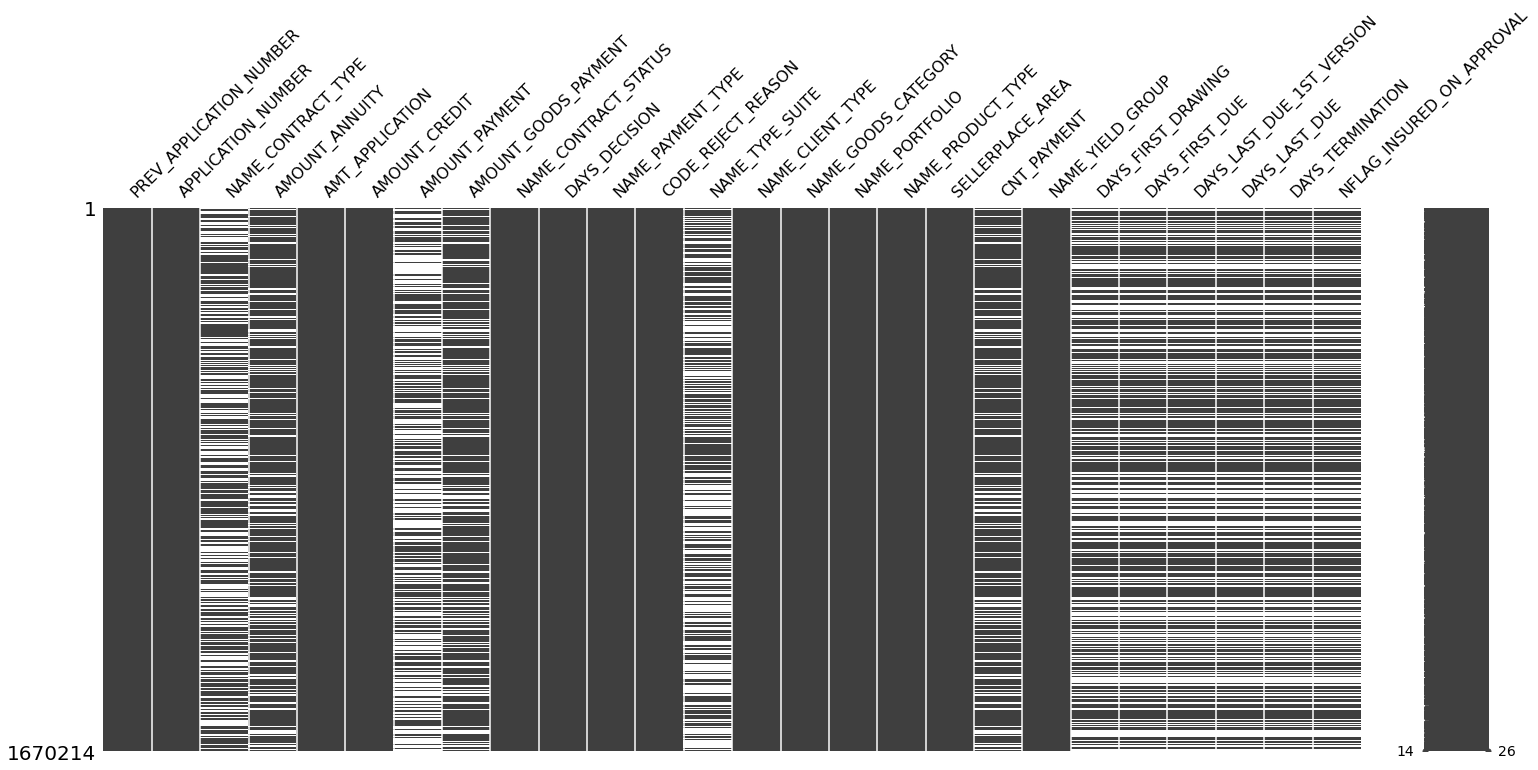

In [549]:
msno.matrix(df_applications_history)

In [550]:
numerical_features_df_applications_history = df_applications_history.select_dtypes(include=[np.number]).columns
numerical_features_df_applications_history = numerical_features_df_applications_history.drop('APPLICATION_NUMBER')
numerical_features_df_applications_history = numerical_features_df_applications_history.drop('PREV_APPLICATION_NUMBER')
numerical_features_df_applications_history

Index(['AMOUNT_ANNUITY', 'AMT_APPLICATION', 'AMOUNT_CREDIT', 'AMOUNT_PAYMENT',
       'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

NAME_CONTRACT_TYPE

In [551]:
df_applications_history['NAME_CONTRACT_TYPE'].value_counts()

Cash           747553
Credit Card    193164
Name: NAME_CONTRACT_TYPE, dtype: int64

In [552]:
df_applications_history['NAME_CONTRACT_TYPE'] = (df_applications_history['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)

AMOUNT_ANNUITY, AMOUNT_GOODS_PAYMENT

In [553]:
df_applications_history = df_applications_history.fillna(value=
                                                         {'AMOUNT_ANNUITY': 0, 
                                                          'AMOUNT_GOODS_PAYMENT': 0})

AMOUNT_PAYMENT

In [554]:
df_applications_history.drop(['AMOUNT_PAYMENT'], axis='columns', inplace=True)
numerical_features_df_applications_history = numerical_features_df_applications_history.drop('AMOUNT_PAYMENT')

NAME_TYPE_SUITE

In [555]:
df_applications_history['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

In [556]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_TYPE_SUITE')

NAME_CONTRACT_STATUS

In [557]:
df_applications_history['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [558]:
freq = pd.Series(data=[1, 0, 0.5, 0.5], index=['Approved', 'Canceled', 'Refused', 'Unused offer'], dtype='float')
df_applications_history['NAME_CONTRACT_STATUS'] = df_applications_history['NAME_CONTRACT_STATUS'].map(freq).astype('float')

NAME_PAYMENT_TYPE

In [559]:
df_applications_history['NAME_PAYMENT_TYPE'].value_counts()

Cash through the bank                        1033552
XNA                                           627384
Non-cash from your account                      8193
Cashless from the account of the employer       1085
Name: NAME_PAYMENT_TYPE, dtype: int64

In [560]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_PAYMENT_TYPE')

CODE_REJECT_REASON

In [561]:
df_applications_history['CODE_REJECT_REASON'].value_counts()

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

In [562]:
df_applications_history = create_freq_feature(df_applications_history, 'CODE_REJECT_REASON')

NAME_CLIENT_TYPE

In [563]:
df_applications_history['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

In [564]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_CLIENT_TYPE')

NAME_GOODS_CATEGORY

In [565]:
df_applications_history['NAME_GOODS_CATEGORY'].value_counts()

XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
Animals                          1
House Construction               1
Name: NAME_GOODS_CAT

In [566]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_GOODS_CATEGORY')

NAME_PORTFOLIO, NAME_PRODUCT_TYPE, NAME_YIELD_GROUP

In [567]:
df_applications_history = create_freq_feature(df_applications_history, 'NAME_PORTFOLIO')
df_applications_history = create_freq_feature(df_applications_history, 'NAME_PRODUCT_TYPE')
df_applications_history = create_freq_feature(df_applications_history, 'NAME_YIELD_GROUP')

Other

In [568]:
df_applications_history = df_applications_history.fillna(0)

numeric

In [30]:
# df_applications_history = numeric_feature_preprocessing(df_applications_history, 
#                                                         numeric_feature=numerical_features_df_applications_history)

visual

In [569]:
standard_scaler = StandardScaler()
df_applications_history_scale = \
            pd.DataFrame(standard_scaler.fit_transform(df_applications_history), 
                         columns=df_applications_history.columns)

In [570]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, learning_rate=250, random_state=42)

In [571]:
df_applications_history_scale.drop(['PREV_APPLICATION_NUMBER', 'APPLICATION_NUMBER'], axis='columns', inplace=True)

In [35]:
%%time

applications_history_tsne = tsne.fit_transform(df_applications_history_scale.sample(2000))

Wall time: 23.4 s


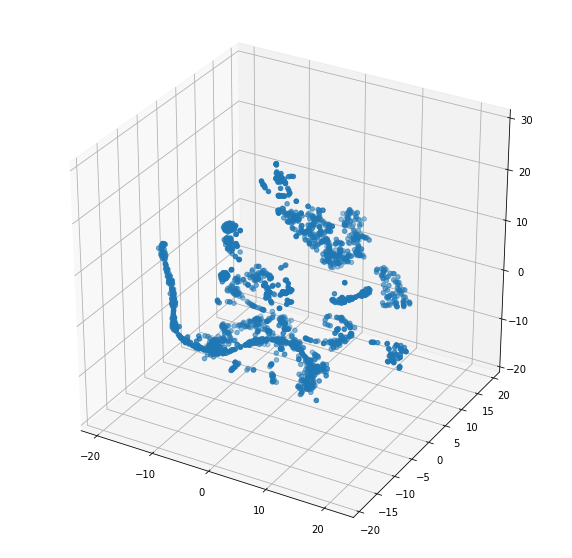

In [36]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 10]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(applications_history_tsne[:, 0],
        applications_history_tsne[:, 1],
        applications_history_tsne[:, 2])

In [575]:
df_train_applications_history.head()

,AMOUNT_ANNUITY,AMOUNT_CREDIT,AMOUNT_GOODS_PAYMENT,AMT_APPLICATION,CNT_PAYMENT,CODE_REJECT_REASON,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_TERMINATION,NAME_CLIENT_TYPE,NAME_CONTRACT_STATUS,NAME_CONTRACT_TYPE,NAME_GOODS_CATEGORY,NAME_PAYMENT_TYPE,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,NAME_TYPE_SUITE,NAME_YIELD_GROUP,NFLAG_INSURED_ON_APPROVAL,PREV_APPLICATION_NUMBER,SELLERPLACE_AREA
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,,,,,,
123713736,3990.555,45000.0,45000.0,45000.0,12.0,0.810132,297,365243.0,263.0,365243.0,365243.0,365243.0,0.737188,1.0,1,0.569274,0.618814,0.413726,0.636844,0.304733,0.309670,0.0,49791645,89
123714035,12478.860,135000.0,135000.0,135000.0,15.0,0.810132,2814,365243.0,2784.0,2514.0,2514.0,2501.0,0.737188,1.0,1,0.569274,0.618814,0.413726,0.636844,0.304733,0.230828,0.0,49819772,1678
123430145,8264.790,67972.5,67972.5,67972.5,16.0,0.810132,1499,365243.0,1468.0,365243.0,1138.0,365243.0,0.180434,1.0,0,0.063327,0.618814,0.413726,0.636844,0.010552,0.211548,0.0,49038286,2000
123622761,13993.020,157756.5,167827.5,167827.5,12.0,0.810132,2515,365243.0,2483.0,2273.0,2273.0,2269.0,0.737188,1.0,0,0.063327,0.618814,0.413726,0.636844,0.127686,0.192847,1.0,49801463,998
123565233,75897.630,2250000.0,2250000.0,2250000.0,60.0,0.810132,1399,365243.0,1365.0,1275.0,1275.0,1271.0,0.737188,1.0,1,0.569274,0.618814,0.413726,0.636844,0.304733,0.230828,1.0,49892456,25


## model

In [577]:
%%time
df_train_applications_history = df_applications_history.copy()

df_train_applications_history = pd.pivot_table(df_train_applications_history,  
                                                index=['APPLICATION_NUMBER'], aggfunc=np.max)


df_train_applications_history = df_train.loc[:, ['APPLICATION_NUMBER', 'TARGET']].merge(
                                               df_train_applications_history, 
                                               left_on='APPLICATION_NUMBER', 
                                               right_on='APPLICATION_NUMBER', 
                                               how='inner')

cor = df_train_applications_history.corr()

# df_train_applications_history, df_valid_applications_history = train_test_split(df_train_applications_history, 
#                                                                                 test_size=0.3,  
#                                                                                 random_state=42)

y_train_applications_history = df_train_applications_history["TARGET"]
# y_valid_applications_history = df_valid_applications_history["TARGET"]

df_train_applications_history.drop(["TARGET", 'APPLICATION_NUMBER', 'PREV_APPLICATION_NUMBER'], axis='columns', inplace=True)
# df_valid_applications_history.drop(["TARGET",'APPLICATION_NUMBER', 'PREV_APPLICATION_NUMBER'], axis='columns', inplace=True)

print("df_train_applications_history.shape = {} rows, {} cols".format(*df_train_applications_history.shape))
# print("df_valid_applications_history.shape = {} rows, {} cols".format(*df_valid_applications_history.shape))

dtrain = lgb.Dataset(data=df_train_applications_history, label=y_train_applications_history)
# dvalid = lgb.Dataset(data=df_valid_applications_history, label=y_valid_applications_history)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 2000,
    "n_jobs": 6,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain],
    early_stopping_rounds=50,
    verbose_eval=500
)

df_train_applications_history.shape = 104656 rows, 23 cols


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 8460, number of negative: 96196
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 104656, number of used features: 23
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080836 -> initscore=-2.431039
[LightGBM] [Info] Start training from score -2.431039
Training until validation scores don't improve for 50 rounds
[500]	training's auc: 0.776248
[1000]	training's auc: 0.833415
[1500]	training's auc: 0.866847
[2000]	training's auc: 0.890539
[2500]	training's auc: 0.908427
[3000]	training's auc: 0.922399
[3500]	training's auc: 0.933697
[4000]	training's auc: 0.942527
[4500]	training's auc: 0.950436
[5000]	training's auc: 0.956907
Did not meet early stopping. B

In [578]:
feature_importances = pd.DataFrame(model_lgb.feature_importance().reshape(-1,len(model_lgb.feature_importance())), columns=model_lgb.feature_name(), index=['importances'])
feature_high_importances = feature_importances.loc[:, 
                                                   feature_importances.loc['importances', :] > feature_importances.loc['importances', :].mean()
                                                  ].columns
feature_importances

,AMOUNT_ANNUITY,AMOUNT_CREDIT,AMOUNT_GOODS_PAYMENT,AMT_APPLICATION,CNT_PAYMENT,CODE_REJECT_REASON,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_TERMINATION,NAME_CLIENT_TYPE,NAME_CONTRACT_STATUS,NAME_CONTRACT_TYPE,NAME_GOODS_CATEGORY,NAME_PAYMENT_TYPE,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,NAME_TYPE_SUITE,NAME_YIELD_GROUP,NFLAG_INSURED_ON_APPROVAL,SELLERPLACE_AREA
importances,20059,15260,14891,359,5649,98,16213,463,11998,8983,13580,6685,1339,19,722,3215,571,347,396,3533,2870,1464,21256


In [579]:
df_train_applications_history["TARGET"] = y_train_applications_history

df_train_applications_history, df_valid_applications_history = train_test_split(df_train_applications_history, 
                                                                                test_size=0.3,  
                                                                                random_state=42)

y_train_applications_history = df_train_applications_history["TARGET"]
y_valid_applications_history = df_valid_applications_history["TARGET"]

df_train_applications_history.drop(["TARGET"], axis='columns', inplace=True)
df_valid_applications_history.drop(["TARGET"], axis='columns', inplace=True)

print("df_train_applications_history.shape = {} rows, {} cols".format(*df_train_applications_history.shape))
print("df_valid_applications_history.shape = {} rows, {} cols".format(*df_valid_applications_history.shape))

dtrain = lgb.Dataset(data=df_train_applications_history, label=y_train_applications_history)
dvalid = lgb.Dataset(data=df_valid_applications_history, label=y_valid_applications_history)

dtrain = lgb.Dataset(data=df_train_applications_history[feature_high_importances], label=y_train_applications_history)
dvalid = lgb.Dataset(data=df_valid_applications_history[feature_high_importances], label=y_valid_applications_history)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 50000,
    "n_jobs": 6,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[ dtrain, dvalid ],
    early_stopping_rounds=1000,
    verbose_eval=500
)

df_train_applications_history.shape = 73259 rows, 23 cols
df_valid_applications_history.shape = 31397 rows, 23 cols
[LightGBM] [Info] Number of positive: 5888, number of negative: 67371
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 73259, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080372 -> initscore=-2.437298
[LightGBM] [Info] Start training from score -2.437298
Training until validation scores don't improve for 1000 rounds


Found `n_estimators` in params. Will use it instead of argument


[500]	training's auc: 0.799021	valid_1's auc: 0.507367
[1000]	training's auc: 0.854432	valid_1's auc: 0.507213
[1500]	training's auc: 0.886008	valid_1's auc: 0.506172
Early stopping, best iteration is:
[714]	training's auc: 0.827772	valid_1's auc: 0.508089


result

In [ ]:
kmeans_n_clusters_df_applications_history = 10

kmeans = KMeans(n_clusters=kmeans_n_clusters_df_applications_history,
                max_iter=10000, random_state=1)

In [ ]:
%%time

kmeans_train = kmeans.fit_predict(df_applications_history_scale[feature_high_importances])

In [ ]:
df_applications_history_result = pd.DataFrame(pd.get_dummies(kmeans_train, prefix='applications_history'))
df_applications_history_result_columns = df_applications_history_result.columns
df_applications_history_result['APPLICATION_NUMBER'] = df_applications_history['APPLICATION_NUMBER']

In [ ]:
df_applications_history_result = pd.pivot_table(df_applications_history_result, 
                                                values=df_applications_history_result_columns, 
                                                index=['APPLICATION_NUMBER'], aggfunc=np.sum)

In [ ]:
df_applications_history_result['sum'] = df_applications_history_result.sum(axis=1)
for col in df_applications_history_result_columns:
    df_applications_history_result[col] = df_applications_history_result[col] / df_applications_history_result['sum']
df_applications_history_result.drop(['sum'], axis='columns', inplace=True)  

In [ ]:
# fig, axes = plt.subplots(figsize = (25,25))
# plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
# sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

In [581]:
df_applications_history_result.head()

,AMOUNT_ANNUITY,AMOUNT_CREDIT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_TERMINATION,SELLERPLACE_AREA
APPLICATION_NUMBER,,,,,,,,,
123423340,3951.000,23787.0,24835.5,1740,1709.0,1619.0,1499.0,1612.0,23
123423341,9251.775,179055.0,179055.0,606,565.0,25.0,125.0,17.0,500
123423342,98356.995,1035882.0,900000.0,2341,2310.0,1980.0,1980.0,1976.0,1400
123423343,5357.250,20106.0,24282.0,815,784.0,724.0,694.0,714.0,30
123423344,4813.200,40153.5,44617.5,757,706.0,466.0,376.0,460.0,37


In [582]:
df_train_applications_history = df_applications_history.copy()

df_train_applications_history = pd.pivot_table(df_train_applications_history,  
                                                index=['APPLICATION_NUMBER'], aggfunc=np.max)

df_applications_history_result = df_train_applications_history[feature_high_importances]
#df_applications_history_result['APPLICATION_NUMBER'] = df_train_applications_history['APPLICATION_NUMBER']

# данные БКИ о предыдущих кредитах клиента;
df_bki

In [273]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# данные БКИ о предыдущих кредитах клиента;
df_bki = pd.read_csv(
    "../geekbrains-competitive-data-analysis/bki.csv"
)

print("bki.shape = {} rows, {} cols".format(*df_bki.shape))

bki.shape = 945234 rows, 17 cols


In [274]:
df_bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

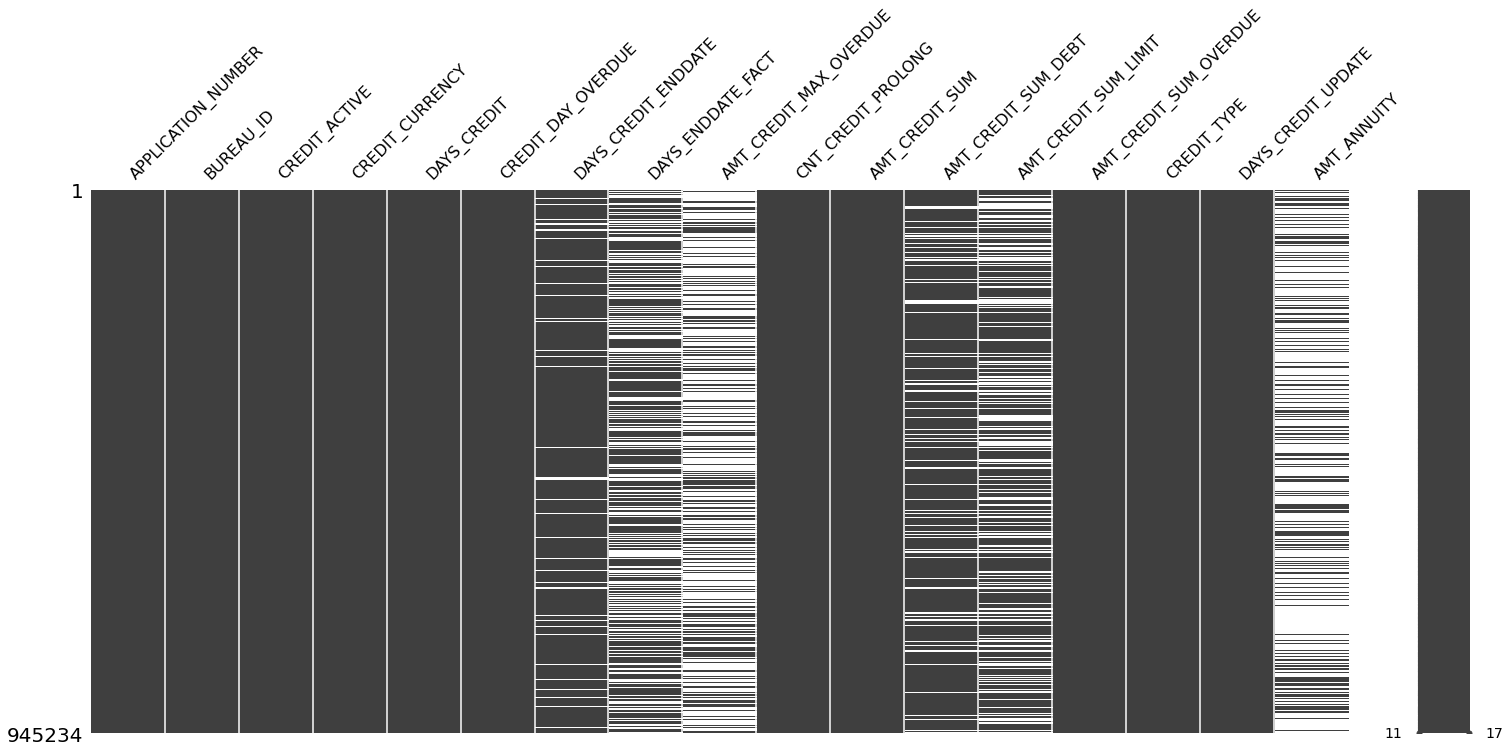

In [275]:
msno.matrix(df_bki)

In [276]:
numerical_features_df_bki = df_bki.select_dtypes(include=[np.number]).columns
numerical_features_df_bki = numerical_features_df_bki.drop('APPLICATION_NUMBER')

numerical_features_df_bki

Index(['BUREAU_ID', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'],
      dtype='object')

CREDIT_ACTIVE, CREDIT_CURRENCY, CREDIT_TYPE

In [277]:
df_bki['CREDIT_ACTIVE'].value_counts()

Closed      594315
Active      347323
Sold          3583
Bad debt        13
Name: CREDIT_ACTIVE, dtype: int64

In [278]:
df_bki['CREDIT_CURRENCY'].value_counts()

currency 1    944492
currency 2       647
currency 3        91
currency 4         4
Name: CREDIT_CURRENCY, dtype: int64

In [279]:
df_bki['CREDIT_TYPE'].value_counts()

Consumer credit                                 688431
Credit card                                     222238
Car loan                                         15348
Mortgage                                         10161
Microloan                                         6788
Loan for business development                     1055
Another type of loan                               586
Unknown type of loan                               300
Loan for working capital replenishment             261
Cash loan (non-earmarked)                           31
Real estate loan                                    16
Loan for the purchase of equipment                  14
Loan for purchase of shares (margin lending)         4
Mobile operator loan                                 1
Name: CREDIT_TYPE, dtype: int64

In [280]:
df_bki = create_freq_feature(df_bki, 'CREDIT_ACTIVE')
df_bki = create_freq_feature(df_bki, 'CREDIT_CURRENCY')
df_bki = create_freq_feature(df_bki, 'CREDIT_TYPE')

DAYS_CREDIT_ENDDATE

In [281]:
mean = df_bki.loc[df_bki['DAYS_CREDIT_ENDDATE'].notnull(), ['DAYS_CREDIT_ENDDATE']].mean()
df_bki['DAYS_CREDIT_ENDDATE'] = df_bki['DAYS_CREDIT_ENDDATE'].fillna(mean[0])

DAYS_ENDDATE_FACT

In [282]:
df_bki.loc[df_bki['DAYS_ENDDATE_FACT'].isnull(), ['DAYS_ENDDATE_FACT']] = df_bki['DAYS_CREDIT_ENDDATE']

AMT_CREDIT_MAX_OVERDUE

In [283]:
df_bki['AMT_CREDIT_MAX_OVERDUE'] = df_bki['AMT_CREDIT_MAX_OVERDUE'].fillna(0)

other

In [284]:
df_bki.drop(['AMT_ANNUITY'], axis='columns', inplace=True)
numerical_features_df_bki = numerical_features_df_bki.drop('AMT_ANNUITY')

In [285]:
df_bki = df_bki.fillna(0)

num

In [286]:
# df_bki = numeric_feature_preprocessing(df_bki, 
#                                        numeric_feature=numerical_features_df_bki)

select feature

In [296]:
%%time
df_train_bki = df_bki.copy()

df_train_bki = pd.pivot_table(df_train_bki,  
                              index=['APPLICATION_NUMBER'], aggfunc=np.max)


df_train_bki = df_train.loc[:, ['APPLICATION_NUMBER', 'TARGET']].merge(
                           df_train_bki, 
                           left_on='APPLICATION_NUMBER', 
                           right_on='APPLICATION_NUMBER', 
                           how='inner')

cor = df_train_bki.corr()

# df_train_bki, df_valid_bki = train_test_split(df_train_bki, 
#                                               test_size=0.3,  
#                                               random_state=42)

y_train_bki = df_train_bki["TARGET"]
# y_valid_bki = df_valid_bki["TARGET"]

df_train_bki.drop(["TARGET", 'APPLICATION_NUMBER', 'BUREAU_ID'], axis='columns', inplace=True)
# df_valid_bki.drop(["TARGET",'APPLICATION_NUMBER'], axis='columns', inplace=True)

print("df_train_bki.shape = {} rows, {} cols".format(*df_train_bki.shape))
# print("df_valid_bki.shape = {} rows, {} cols".format(*df_valid_bki.shape))

dtrain = lgb.Dataset(data=df_train_bki, label=y_train_bki)
# dvalid = lgb.Dataset(data=df_valid_bki, label=y_valid_bki)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 5000,
    "n_jobs": 6,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain],
    early_stopping_rounds=50,
    verbose_eval=500
)

feature_importances = pd.DataFrame(model_lgb.feature_importance().reshape(-1,len(model_lgb.feature_importance())), columns=model_lgb.feature_name(), index=['importances'])
feature_high_importances = feature_importances.loc[:, 
                                                   feature_importances.loc['importances', :] > feature_importances.loc['importances', :].mean()
                                                  ].columns
print(feature_importances)


df_train_bki["TARGET"] = y_train_bki

df_train_bki, df_valid_bki = train_test_split(df_train_bki, 
                                              test_size=0.3,  
                                              random_state=42)

y_train_bki = df_train_bki["TARGET"]
y_valid_bki = df_valid_bki["TARGET"]

df_train_bki.drop(["TARGET"], axis='columns', inplace=True)
df_valid_bki.drop(["TARGET"], axis='columns', inplace=True)

print("df_train_bki.shape = {} rows, {} cols".format(*df_train_bki.shape))
print("df_valid_bki.shape = {} rows, {} cols".format(*df_valid_bki.shape))

dtrain = lgb.Dataset(data=df_train_bki[feature_high_importances], label=y_train_bki)
dvalid = lgb.Dataset(data=df_valid_bki[feature_high_importances], label=y_valid_bki)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 50000,
    "n_jobs": 6,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[ dtrain, dvalid ],
    early_stopping_rounds=1000,
    verbose_eval=500
)

df_train_bki.shape = 84508 rows, 14 cols
[LightGBM] [Info] Number of positive: 6904, number of negative: 77604
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 84508, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081696 -> initscore=-2.419518
[LightGBM] [Info] Start training from score -2.419518
Training until validation scores don't improve for 50 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[500]	training's auc: 0.763562
[1000]	training's auc: 0.813935
[1500]	training's auc: 0.847438
[2000]	training's auc: 0.871038
[2500]	training's auc: 0.889858
[3000]	training's auc: 0.903449
[3500]	training's auc: 0.915246
[4000]	training's auc: 0.924755
[4500]	training's auc: 0.932871
[5000]	training's auc: 0.940367
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.940367
             AMT_CREDIT_MAX_OVERDUE  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
importances                    8933           25564                18024   

             AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  CNT_CREDIT_PROLONG  \
importances                  6504                     864                 340   

             CREDIT_ACTIVE  CREDIT_CURRENCY  CREDIT_DAY_OVERDUE  CREDIT_TYPE  \
importances            627               26                 633         1178   

             DAYS_CREDIT  DAYS_CREDIT_ENDDATE  DAYS_CREDIT_UPDATE  \
importances        26084                18854          

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[500]	training's auc: 0.797096	valid_1's auc: 0.508629
[1000]	training's auc: 0.850106	valid_1's auc: 0.508784
Early stopping, best iteration is:
[32]	training's auc: 0.572243	valid_1's auc: 0.514103
Wall time: 1min 2s


scale

In [297]:
df_bki_scale = pd.DataFrame(standard_scaler.fit_transform(df_bki), 
               columns=df_bki.columns)

In [298]:
df_bki_scale.drop(['APPLICATION_NUMBER', 'BUREAU_ID'], axis='columns', inplace=True)

In [299]:
kmeans_bki = KMeans(n_clusters=10, max_iter=10000, random_state=1)

In [300]:
%%time

kmeans_train_bki = kmeans_bki.fit_predict(df_bki_scale[feature_high_importances])

Wall time: 19.4 s


In [301]:
df_bki_result = pd.DataFrame(pd.get_dummies(kmeans_train_bki, prefix='bki'))
df_bki_result_columns = df_bki_result.columns
df_bki_result['APPLICATION_NUMBER'] = df_bki['APPLICATION_NUMBER']

In [302]:
df_bki_result = pd.pivot_table(df_bki_result, values=df_bki_result_columns, index=['APPLICATION_NUMBER'], aggfunc=np.sum)

In [303]:
df_bki_result['sum'] = df_bki_result.sum(axis=1)
for col in df_bki_result_columns:
    df_bki_result[col] = df_bki_result[col] / df_bki_result['sum']
df_bki_result.drop(['sum'], axis='columns', inplace=True)  

In [304]:
df_bki_result

,bki_0,bki_1,bki_2,bki_3,bki_4,bki_5,bki_6,bki_7,bki_8,bki_9
APPLICATION_NUMBER,,,,,,,,,,
123423340,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0
123423341,0.200000,0.0,0.0,0.000000,0.0,0.200000,0.0,0.0,0.600000,0.0
123423342,0.500000,0.0,0.0,0.500000,0.0,0.000000,0.0,0.0,0.000000,0.0
123423343,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0
123423344,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
123779588,0.272727,0.0,0.0,0.272727,0.0,0.363636,0.0,0.0,0.090909,0.0
123779589,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
123779592,0.500000,0.0,0.5,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


# история платежей клиента;
df_payments

In [67]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# история платежей клиента;
df_payments = pd.read_csv(
    "../geekbrains-competitive-data-analysis/payments.csv"
)

print("payments.shape = {} rows, {} cols".format(*df_payments.shape))
df_payments.head()

payments.shape = 1023932 rows, 8 cols


,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735


In [68]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [69]:
numerical_features_df_payments = df_payments.select_dtypes(include=[np.number]).columns
numerical_features_df_payments = numerical_features_df_payments.drop('APPLICATION_NUMBER')
numerical_features_df_payments = numerical_features_df_payments.drop('PREV_APPLICATION_NUMBER')

numerical_features_df_payments

Index(['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [70]:
df_payments = df_payments.fillna(0)

In [71]:
# df_payments = numeric_feature_preprocessing(df_payments, 
#                                             numeric_feature=numerical_features_df_payments)

In [72]:
df_payments_scale = pd.DataFrame(standard_scaler.fit_transform(df_payments), 
               columns=df_payments.columns)

df_payments_scale.drop(['APPLICATION_NUMBER', 'PREV_APPLICATION_NUMBER'], axis='columns', inplace=True)

In [73]:
kmeans_payments = KMeans(n_clusters=10, max_iter=10000, random_state=1)

In [74]:
%%time

kmeans_train_payments = kmeans_payments.fit_predict(df_payments_scale)

Wall time: 23.7 s


In [75]:
df_payments_result = pd.DataFrame(pd.get_dummies(kmeans_train_payments, prefix='payments'))
df_payments_result_columns = df_payments_result.columns
df_payments_result['APPLICATION_NUMBER'] = df_payments['APPLICATION_NUMBER']

In [76]:
df_payments_result = pd.pivot_table(df_payments_result, values=df_payments_result_columns, index=['APPLICATION_NUMBER'], aggfunc=np.sum)

In [77]:
df_payments_result['sum'] = df_payments_result.sum(axis=1)
for col in df_payments_result_columns:
    df_payments_result[col] = df_payments_result[col] / df_payments_result['sum']
df_payments_result.drop(['sum'], axis='columns', inplace=True)  

In [78]:
df_train_payments = df_train.merge(df_payments_result, 
                                   left_on='APPLICATION_NUMBER', 
                                   right_on='APPLICATION_NUMBER', 
                                   how='inner')

cor = df_train_payments.corr()

df_train_payments, df_valid_payments = train_test_split(df_train_payments, 
                                                        test_size=0.3,  
                                                        random_state=42)

y_train_payments = df_train_payments["TARGET"]
y_valid_payments = df_valid_payments["TARGET"]

df_train_payments.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)
df_valid_payments.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)

print("df_train_payments = {} rows, {} cols".format(*df_train_payments.shape))
print("df_valid_payments.shape = {} rows, {} cols".format(*df_valid_payments.shape))

df_train_payments = 57376 rows, 11 cols
df_valid_payments.shape = 24591 rows, 11 cols


In [79]:
%%time
dtrain = lgb.Dataset(data=df_train_payments, label=y_train_payments)
dvalid = lgb.Dataset(data=df_valid_payments, label=y_valid_payments)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.001,
    "n_estimators": 10000,
    "n_jobs": 4,
    "seed": 20
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=500
)

[LightGBM] [Info] Number of positive: 4595, number of negative: 52781
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 57376, number of used features: 11
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080086 -> initscore=-2.441183
[LightGBM] [Info] Start training from score -2.441183
Training until validation scores don't improve for 100 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[65]	training's auc: 0.548633	valid_1's auc: 0.526684
Wall time: 885 ms


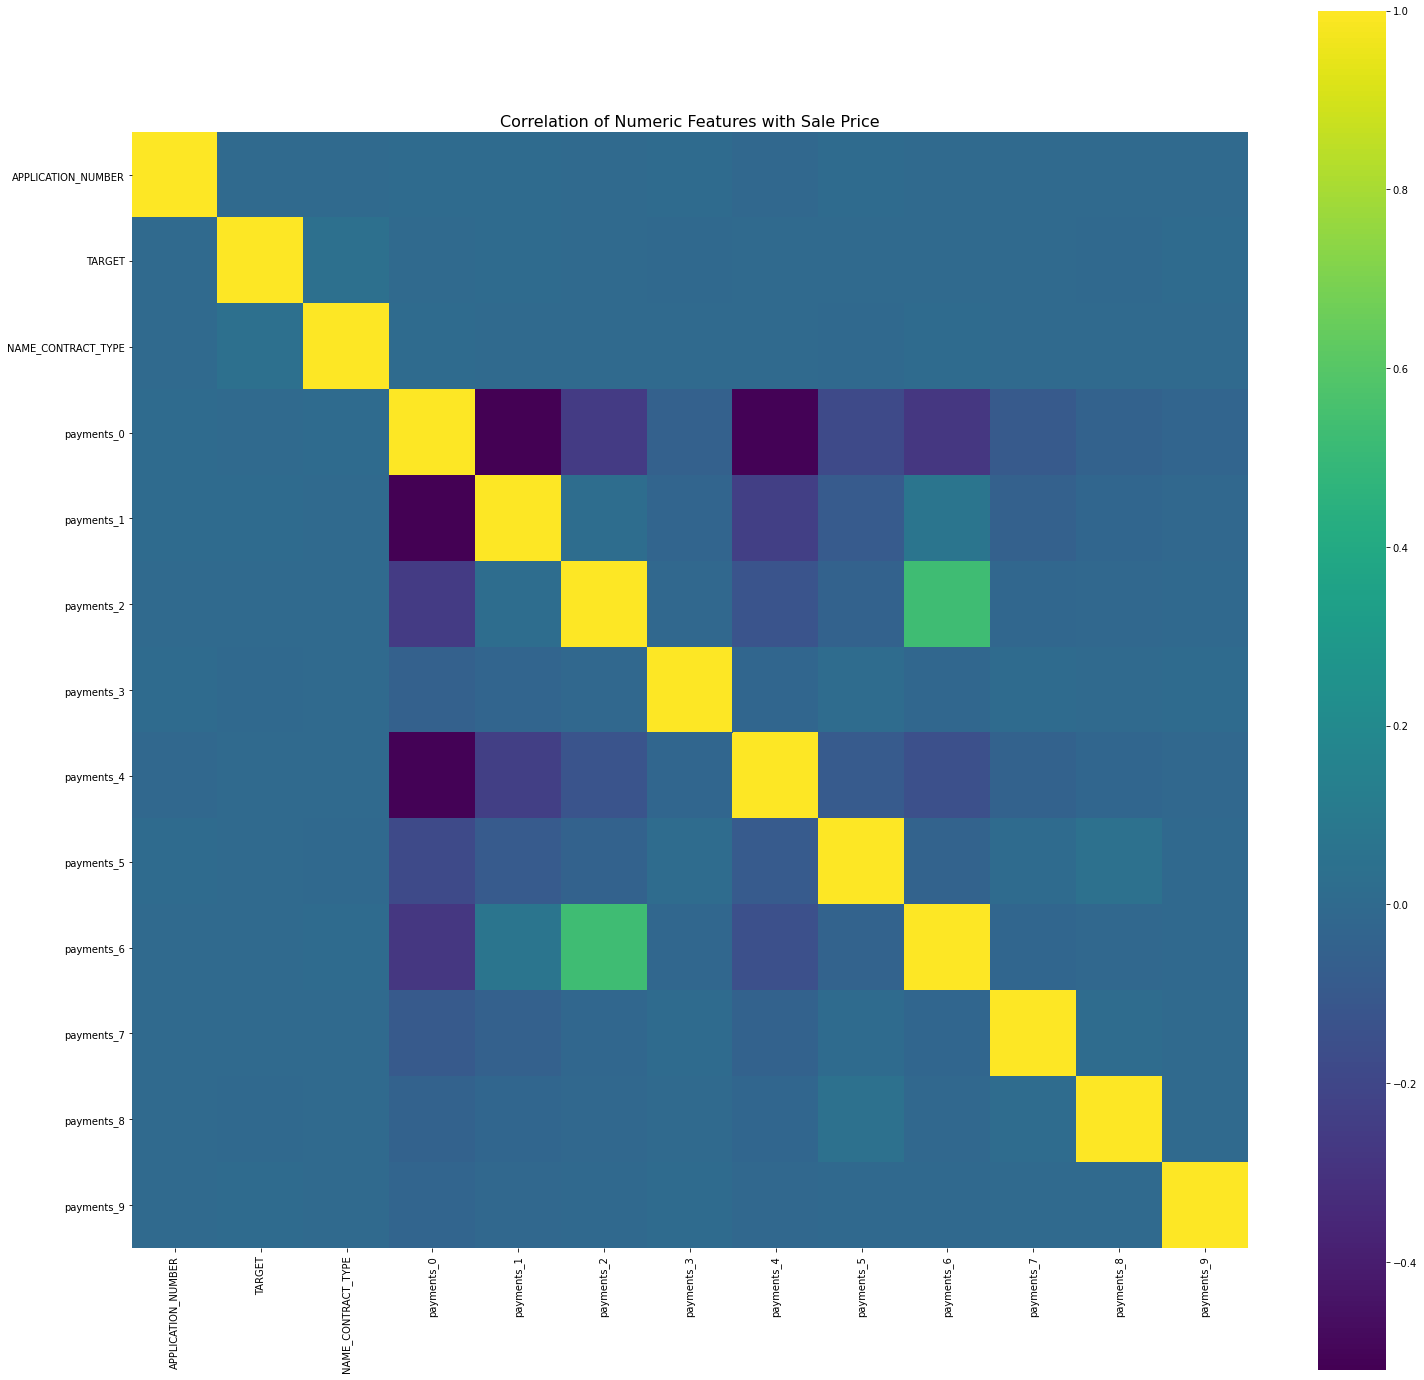

In [80]:
fig, axes = plt.subplots(figsize = (25,25))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

# клиентский профиль, некоторые знания, которые есть у компании о клиенте;
df_client_profile

In [444]:
# клиентский профиль, некоторые знания, которые есть у компании о клиенте;
df_client_profile = pd.read_csv(
    "../geekbrains-competitive-data-analysis/client_profile.csv"
)

print("client_profile.shape = {} rows, {} cols".format(*df_client_profile.shape))
df_client_profile.head()

client_profile.shape = 250000 rows, 24 cols


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,1726,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,365243,NaN,0,0,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [445]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

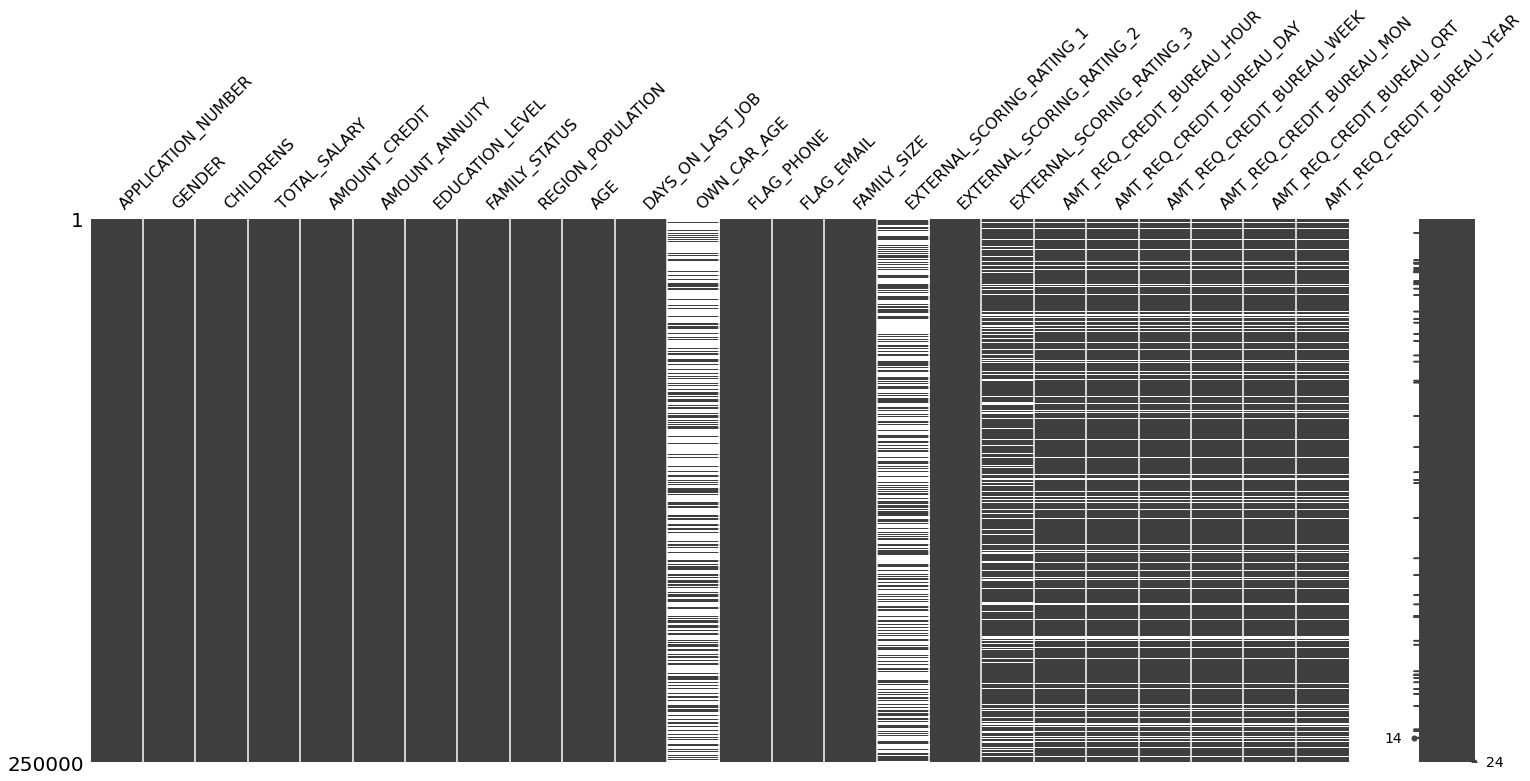

In [446]:
msno.matrix(df_client_profile)

GENDER

In [447]:
df_client_profile['GENDER'].value_counts()

F      164645
M       85351
XNA         4
Name: GENDER, dtype: int64

In [448]:
df_client_profile['GENDER'] = (df_client_profile['GENDER'] == 'F').astype(int)

FAMILY_STATUS,EDUCATION_LEVEL

In [449]:
df_client_profile['FAMILY_STATUS'].value_counts()

Married                 159846
Single / not married     36883
Civil marriage           24252
Separated                15984
Widow                    13033
Unknown                      2
Name: FAMILY_STATUS, dtype: int64

In [450]:
df_client_profile['EDUCATION_LEVEL'].value_counts()

Secondary / secondary special    177562
Higher education                  60864
Incomplete higher                  8357
Lower secondary                    3081
Academic degree                     136
Name: EDUCATION_LEVEL, dtype: int64

In [451]:
df_client_profile = create_freq_feature(df_client_profile, 'FAMILY_STATUS')
df_client_profile = create_freq_feature(df_client_profile, 'EDUCATION_LEVEL')

In [452]:
df_client_profile = df_client_profile.fillna(value=
                                             {'OWN_CAR_AGE': 0, 
                                              'EXTERNAL_SCORING_RATING_1': df_client_profile['EXTERNAL_SCORING_RATING_1'].min(),
                                              'EXTERNAL_SCORING_RATING_3': df_client_profile['EXTERNAL_SCORING_RATING_3'].min()
                                             })

df_client_profile = df_client_profile.fillna(0)

In [453]:
df_client_profile.describe().T

,count,mean,std,min,25%,50%,75%,max
APPLICATION_NUMBER,250000.0,1.235771e+08,88777.222374,1.234233e+08,1.235002e+08,1.235772e+08,1.236540e+08,1.237309e+08
GENDER,250000.0,6.585800e-01,0.474187,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CHILDRENS,250000.0,4.176240e-01,0.722529,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.900000e+01
TOTAL_SALARY,250000.0,1.690662e+05,258847.985752,2.565000e+04,1.125000e+05,1.485000e+05,2.025000e+05,1.170000e+08
AMOUNT_CREDIT,250000.0,5.993051e+05,402272.024068,4.500000e+04,2.700000e+05,5.147775e+05,8.086500e+05,4.050000e+06
AMOUNT_ANNUITY,250000.0,2.712402e+04,14504.727260,0.000000e+00,1.652400e+04,2.493000e+04,3.461400e+04,2.301615e+05
EDUCATION_LEVEL,250000.0,5.649927e-01,0.231384,5.440000e-04,2.434560e-01,7.102480e-01,7.102480e-01,7.102480e-01
FAMILY_STATUS,250000.0,4.467937e-01,0.257469,8.000000e-06,1.475320e-01,6.393840e-01,6.393840e-01,6.393840e-01
REGION_POPULATION,250000.0,2.087081e-02,0.013827,2.900000e-04,1.000600e-02,1.885000e-02,2.866300e-02,7.250800e-02
AGE,250000.0,1.603346e+04,4361.332320,7.489000e+03,1.241500e+04,1.574400e+04,1.968100e+04,2.522900e+04


In [454]:
df_train = pd.read_csv(
    "../geekbrains-competitive-data-analysis/train.csv"
)

In [455]:
df_train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [456]:
df_client_profile_t = df_client_profile.merge(df_train.loc[:, ['APPLICATION_NUMBER', 'TARGET']], 
                                            left_on='APPLICATION_NUMBER', 
                                            right_on='APPLICATION_NUMBER', 
                                            how='inner')


In [457]:
df_client_profile_t

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,123501780,0,1,427500.0,239850.0,23850.0,0.033428,0.639384,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,0.000527,0.0,0.0,0.0,0.0,0.0,0.0,0
1,123549827,1,0,108000.0,835380.0,35523.0,0.710248,0.639384,0.019101,16213,2618,0.0,0,0,2.0,0.014691,0.434042,0.646330,0.0,0.0,0.0,0.0,1.0,2.0,0
2,123657397,0,0,135000.0,592560.0,31023.0,0.710248,0.639384,0.018029,9219,2412,0.0,0,0,2.0,0.014691,0.366381,0.000527,0.0,0.0,0.0,0.0,0.0,0.0,0
3,123712664,1,1,220500.0,1113840.0,47322.0,0.710248,0.097008,0.046220,14010,3489,0.0,0,0,3.0,0.418500,0.559779,0.000527,0.0,0.0,0.0,0.0,0.0,3.0,0
4,123543714,1,1,76500.0,177768.0,8550.0,0.710248,0.639384,0.010500,17203,8280,0.0,1,0,3.0,0.434592,0.541889,0.517297,0.0,0.0,0.0,2.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89534,123487391,1,0,135000.0,219042.0,26122.5,0.033428,0.147532,0.019101,10389,2009,8.0,0,1,1.0,0.753519,0.411172,0.000527,0.0,0.0,0.0,0.0,0.0,0.0,0
89535,123517831,0,0,112500.0,269982.0,28480.5,0.710248,0.147532,0.018029,8130,1307,18.0,0,0,1.0,0.167356,0.276593,0.365617,0.0,0.0,0.0,0.0,0.0,3.0,0
89536,123578622,1,0,90000.0,71955.0,7137.0,0.710248,0.639384,0.015221,16954,3201,7.0,1,0,2.0,0.014691,0.373266,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,0
89537,123616079,1,0,135000.0,534204.0,29956.5,0.710248,0.639384,0.007330,20666,365243,0.0,0,0,2.0,0.014691,0.468374,0.694093,0.0,0.0,0.0,0.0,0.0,2.0,0


In [498]:
%%time

dtrain = xgb.DMatrix(data=df_client_profile_t.iloc[:, :df_client_profile_t.shape[1]-1], 
                     label=df_client_profile_t.iloc[:, df_client_profile_t.shape[1]-1])
print('*')

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 500,
    "reg_lambda": 100,
    "max_depth": 10,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train")],
    verbose_eval=100,
    maximize=True,
)

*
[17:23:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.57937
Will train until train-auc hasn't improved in 50 rounds.
[100]	train-auc:0.69662
[200]	train-auc:0.71631
[300]	train-auc:0.73384
[400]	train-auc:0.74286
[500]	train-auc:0.74862
[600]	train-auc:0.75226
[700]	train-auc:0.75490
Stopping. Best iteration:
[721]	train-auc:0.75516

Wall time: 1min 32s


In [499]:
x_valid_ = df_client_profile_t.sample(5000)
y_valid_ =  x_valid_['TARGET']
x_valid_.drop(['TARGET'], axis='columns', inplace=True)

In [500]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(x_valid_, y_valid_)

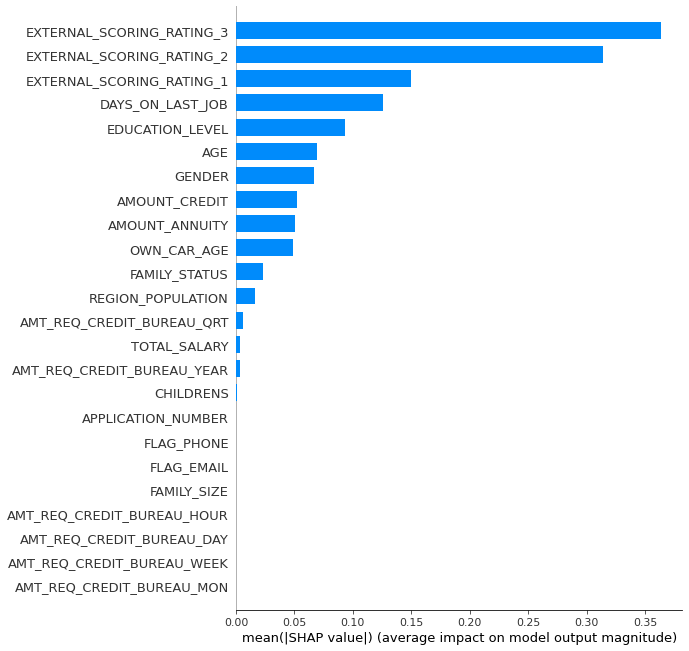

In [501]:
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=150)

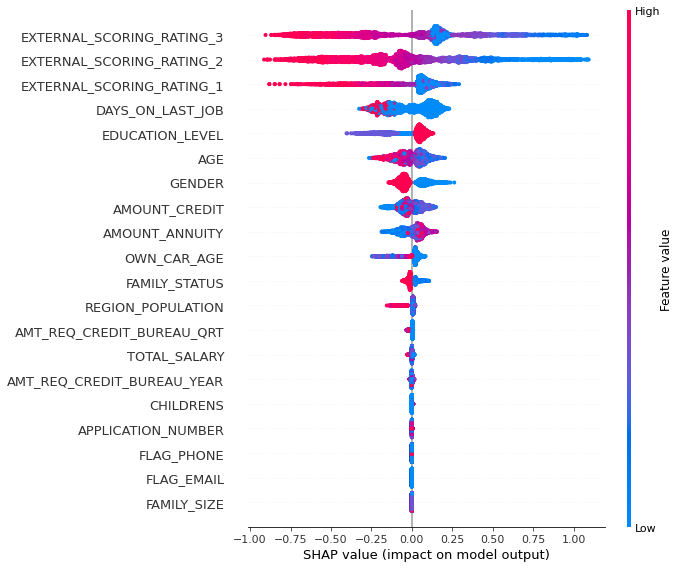

In [502]:
shap.summary_plot(shap_values, x_valid_, plot_type="dot")

In [503]:
mean = list()

for j in range(shap_values.shape[1]):
    bufer = 0
    for i in range(shap_values.shape[0]):
        bufer += np.abs(shap_values[i][j])
    bufer /= shap_values.shape[0]
    mean.append(bufer)

mean = np.array(mean).reshape(-1, shap_values.shape[1])

feature_importances = pd.DataFrame(mean, columns=x_valid_.columns, index=['importances'])
feature_importances = feature_importances.sort_values('importances', axis=1, ascending=0)
max_num_feature = feature_importances.loc['importances', feature_importances.loc['importances',:]>0].shape[0]
feature_high_importances = feature_importances.iloc[: ,0:max_num_feature].columns
feature_high_importances

Index(['EXTERNAL_SCORING_RATING_3', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_1', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL',
       'AGE', 'GENDER', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'OWN_CAR_AGE',
       'FAMILY_STATUS', 'REGION_POPULATION', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'TOTAL_SALARY', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS',
       'APPLICATION_NUMBER'],
      dtype='object')

[LightGBM] [Info] Number of positive: 4214, number of negative: 49509
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2400
[LightGBM] [Info] Number of data points in the train set: 53723, number of used features: 17
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078439 -> initscore=-2.463742
[LightGBM] [Info] Start training from score -2.463742
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.756961	valid_1's auc: 0.734915
[200]	training's auc: 0.781132	valid_1's auc: 0.742727
[300]	training's auc: 0.798448	valid_1's auc: 0.746753
[400]	training's auc: 0.813368	valid_1's auc: 0.749323
[500]	training's auc: 0.826707	valid_1's auc: 0.7502
Early stopping, best iteration is:
[471]	training's auc: 0.823206	valid_1's auc: 0.750236


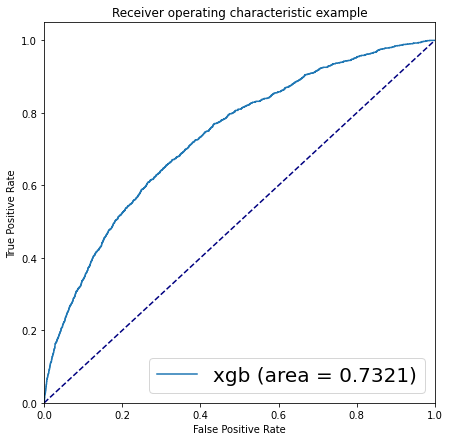

Wall time: 5.78 s


In [504]:
%%time

df_train_, df_valid_ = train_test_split(df_client_profile_t, 
                                        test_size=0.4,  
                                        random_state=42)
df_valid_, df_test_ = train_test_split(df_valid_, 
                                        test_size=0.5,  
                                        random_state=42)

dtrain = lgb.Dataset(data=df_train_[feature_high_importances], 
                     label=df_train_['TARGET'])
dvalid = lgb.Dataset(data=df_valid_[feature_high_importances], 
                     label=df_valid_['TARGET'])

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

#------------------------------------------------------------------------------
#lgb
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

pred = model_lgb.predict(df_test_[feature_high_importances])
fpr, tpr, _ = roc_curve(df_test_['TARGET'], pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='xgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [505]:
df_client_profile_result = df_client_profile[feature_high_importances]
df_client_profile_result['APPLICATION_NUMBER'] = df_client_profile['APPLICATION_NUMBER']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Объединение

In [583]:
df_train = pd.read_csv(
    "../geekbrains-competitive-data-analysis/train.csv"
)

df_test = pd.read_csv(
    "../geekbrains-competitive-data-analysis/test.csv"
)

print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 110093 rows, 3 cols
df_test.shape = 165141 rows, 2 cols


In [584]:
#df_train = create_dummie(df_train)
#df_test = create_dummie(df_test)

df_train['NAME_CONTRACT_TYPE'] = (df_train['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)
df_test['NAME_CONTRACT_TYPE'] = (df_test['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)

In [585]:
df_train, df_valid = train_test_split(df_train, 
                                      test_size=0.3,  
                                      random_state=42)

In [586]:
print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 77065 rows, 3 cols
df_valid.shape = 33028 rows, 3 cols
df_test.shape = 165141 rows, 2 cols


In [587]:
df_train = df_train.merge(df_client_profile_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_valid = df_valid.merge(df_client_profile_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_client_profile_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

In [588]:
df_train = df_train.merge(df_applications_history_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_valid = df_valid.merge(df_applications_history_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_applications_history_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

In [589]:
df_train = df_train.merge(df_bki_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_valid = df_valid.merge(df_bki_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_bki_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

In [590]:
df_train = df_train.merge(df_payments_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_valid = df_valid.merge(df_payments_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_payments_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

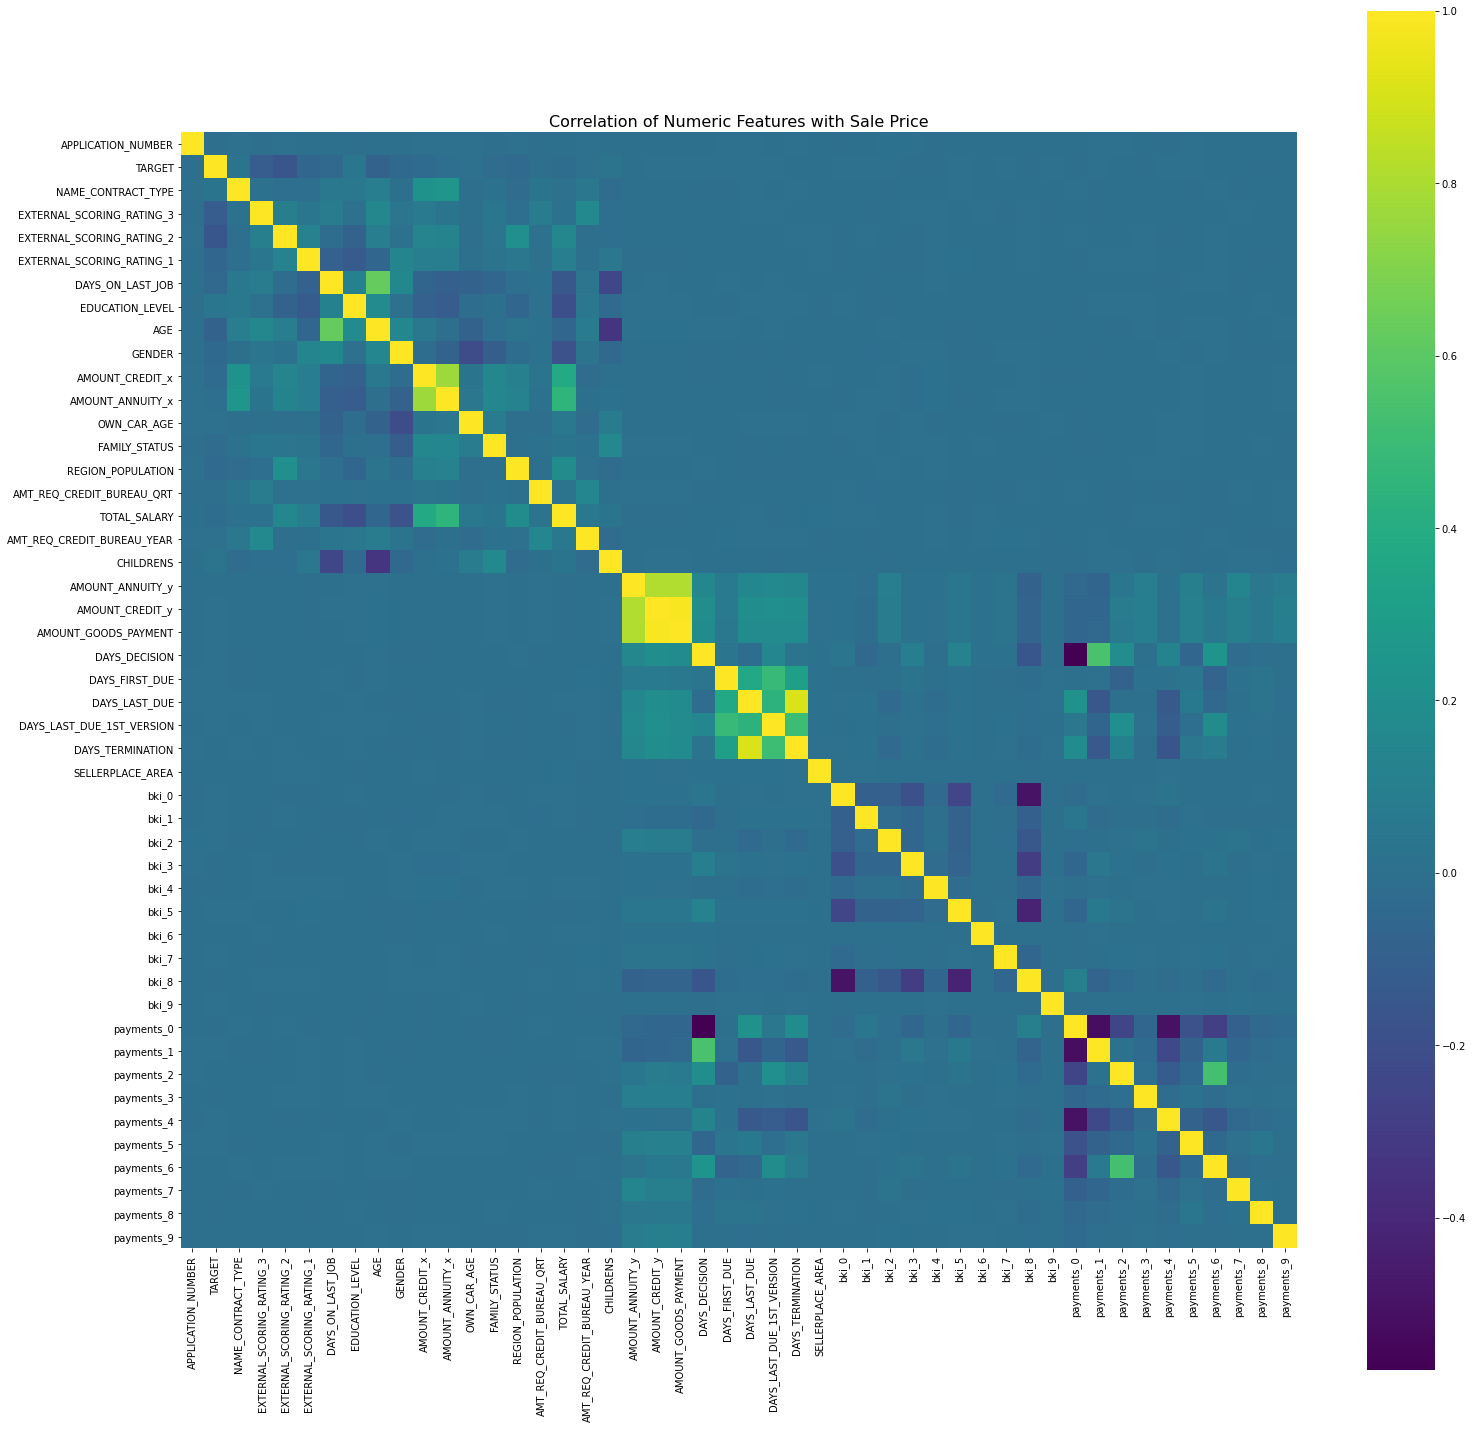

In [591]:
cor = df_train.corr()
fig, axes = plt.subplots(figsize = (25,25))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(cor, square=True, vmax=1, cmap="viridis")

In [592]:
y_train = df_train["TARGET"]
y_valid = df_valid["TARGET"]

df_train.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)
df_valid.drop(["TARGET", 'APPLICATION_NUMBER'], axis='columns', inplace=True)

In [593]:
df_test.drop(['APPLICATION_NUMBER'], axis='columns', inplace=True)

In [594]:
print("df_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

df_train.shape = 77065 rows, 46 cols
df_valid.shape = 33028 rows, 46 cols
df_test.shape = 165141 rows, 46 cols


In [595]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
NAME_CONTRACT_TYPE,77065.0,0.904821,0.293464,0.000000,1.000000,1.000000,1.000000,1.000000e+00
EXTERNAL_SCORING_RATING_3,62565.0,0.409682,0.268573,0.000527,0.176653,0.457900,0.636376,8.939761e-01
EXTERNAL_SCORING_RATING_2,62565.0,0.512879,0.192209,0.000000,0.390946,0.564537,0.663148,8.549997e-01
EXTERNAL_SCORING_RATING_1,62565.0,0.228000,0.279031,0.014691,0.014691,0.014691,0.458989,9.516240e-01
DAYS_ON_LAST_JOB,62565.0,67877.502374,139567.912347,2.000000,927.000000,2212.000000,5755.000000,3.652430e+05
EDUCATION_LEVEL,62565.0,0.563813,0.232196,0.000544,0.243456,0.710248,0.710248,7.102480e-01
AGE,62565.0,16054.325230,4356.566265,7679.000000,12458.000000,15760.000000,19699.000000,2.518700e+04
GENDER,62565.0,0.660257,0.473626,0.000000,0.000000,1.000000,1.000000,1.000000e+00
AMOUNT_CREDIT_x,62565.0,601831.660681,404484.419564,45000.000000,270000.000000,518562.000000,808650.000000,4.050000e+06
AMOUNT_ANNUITY_x,62565.0,27163.840782,14496.774046,0.000000,16551.000000,24939.000000,34695.000000,2.250000e+05


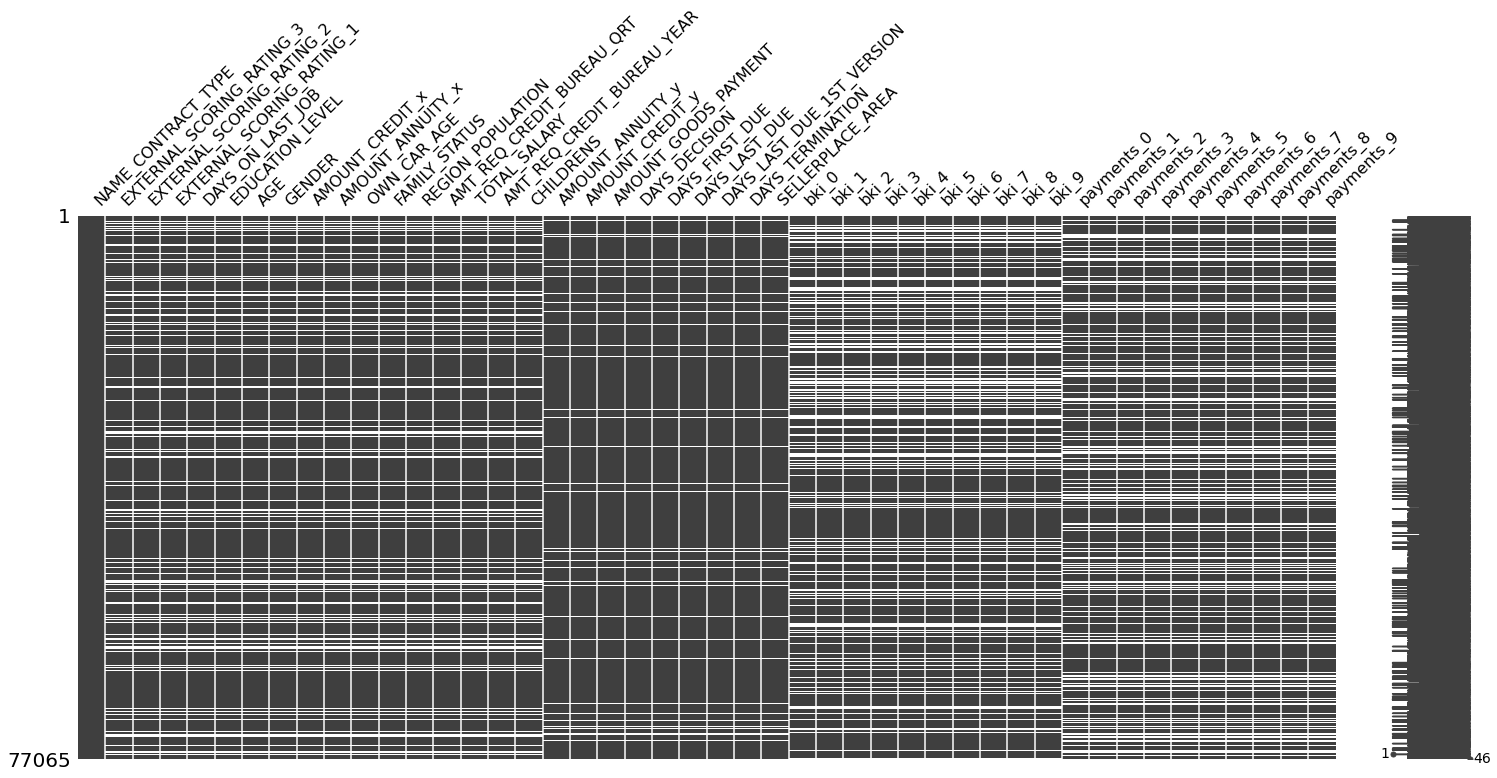

In [596]:
msno.matrix(df_train)

In [597]:
%%time

dtrain = xgb.DMatrix(data=df_train.fillna(-9999), label=y_train)
print('*')
dvalid = xgb.DMatrix(data=df_valid.fillna(-9999), label=y_valid)
print('*')
dtest = xgb.DMatrix(data=df_test.fillna(-9999))

*
*
Wall time: 540 ms


In [598]:
%%time

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 10,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=100,
    maximize=True,
)

[17:50:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	valid-auc:0.50000
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.67414	valid-auc:0.67569
[200]	train-auc:0.69076	valid-auc:0.69047
[300]	train-auc:0.70517	valid-auc:0.70351
[400]	train-auc:0.71618	valid-auc:0.71349
[500]	train-auc:0.72108	valid-auc:0.71749
[600]	train-auc:0.72410	valid-auc:0.72007
Stopping. Best iteration:
[642]	train-auc:0.72526	valid-auc:0.72069

Wall time: 1min 48s


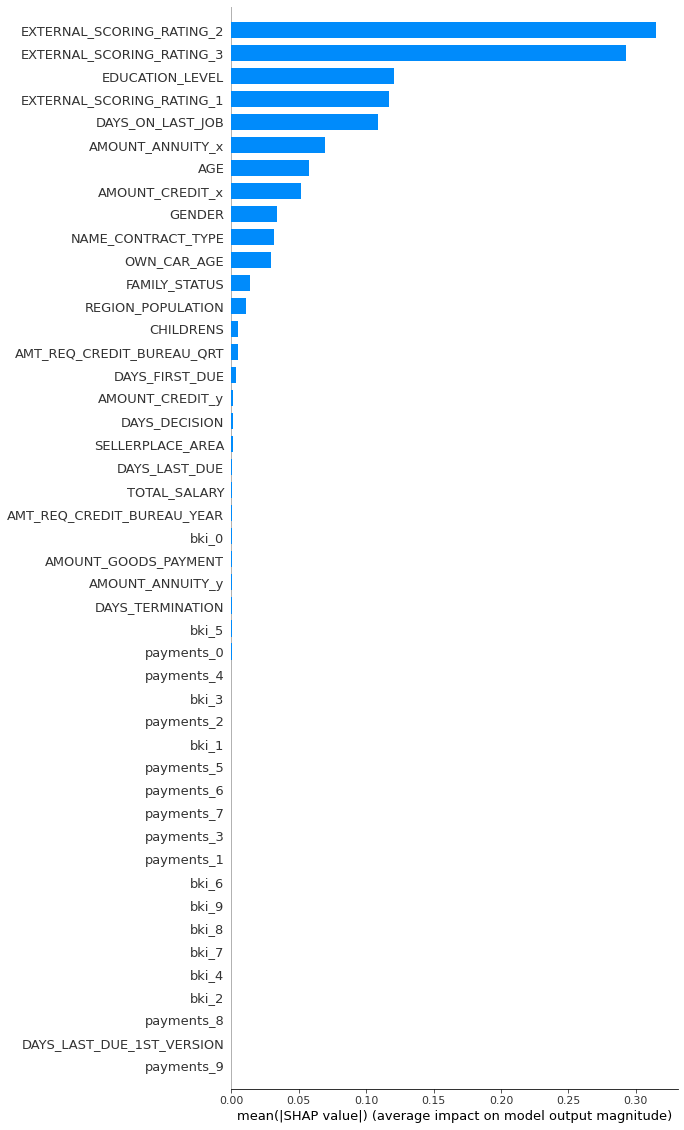

In [599]:
x_valid_ = df_valid.fillna(-9999).sample(5000)
y_valid_ =  y_valid.sample(5000)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(x_valid_, y_valid_)

shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=150)

In [600]:
%%time

dtrain = lgb.Dataset(data=df_train.fillna(-9999), label=y_train)
dvalid = lgb.Dataset(data=df_valid.fillna(-9999), label=y_valid)
dtest = lgb.Dataset(data=df_test.fillna(-9999))

Wall time: 90 ms


In [601]:
%%time

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 5000,
    "n_jobs": 6,
    "seed": 27
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 6277, number of negative: 70788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5529
[LightGBM] [Info] Number of data points in the train set: 77065, number of used features: 46
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081451 -> initscore=-2.422797
[LightGBM] [Info] Start training from score -2.422797
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.72319	valid_1's auc: 0.70848
[200]	training's auc: 0.748718	valid_1's auc: 0.717344
[300]	training's auc: 0.767443	valid_1's auc: 0.722089
[400]	training's auc: 0.782594	valid_1's auc: 0.72445
Early stopping, best iteration is:
[443]	training's auc: 0.788352	valid_1's auc: 0.725192
Wall time: 9.82 s


In [602]:
result = model_lgb.predict(df_test.fillna(-9999))
result

array([0.0794865 , 0.2308335 , 0.18604543, ..., 0.08850746, 0.03349669,
       0.05277542])

In [603]:
df_sample_submit["TARGET"] = df_sample_submit["TARGET"].astype('float')

In [604]:
df_sample_submit["TARGET"] = result

In [605]:
df_sample_submit.to_csv('result.csv', index=False) 